In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

# ODEs
from scipy.optimize import curve_fit
from scipy.integrate import solve_ivp

# Networks
import networkx as nx
import EoN
from collections import defaultdict 

%matplotlib notebook

In [22]:
# Run to choose which 1 out of 4 files to use
datasets = [
    'trump_chanting_verified.csv',
    'judicial_watch_alleges_stolen_election_raw.csv',
    'ballot_harvesting_ilhan_omar_project_veritas_video_raw.csv',
    'machines_westmoreland_machines_down_raw.csv'
]

print('Type a number coresponding to the file:\n')

print('1 -> trump_chanting_verified.csv')
print('2 -> judicial_watch_alleges_stolen_election_raw.csv')
print('3 -> ballot_harvesting_ilhan_omar_project_veritas_video_raw.csv')
print('4 -> machines_westmoreland_machines_down_raw.csv\n')

index = int(input('Number:'))

if (index < 1 or index > 4):
    raise Exception('Number has to be between 1 and 4 :)')
    
file = datasets[index - 1]

print('\n')
print(f'Chosen: {file}')

Type a number coresponding to the file:

1 -> trump_chanting_verified.csv
2 -> judicial_watch_alleges_stolen_election_raw.csv
3 -> ballot_harvesting_ilhan_omar_project_veritas_video_raw.csv
4 -> machines_westmoreland_machines_down_raw.csv

Number:3


Chosen: ballot_harvesting_ilhan_omar_project_veritas_video_raw.csv


In [23]:
# total_tweets is I (Infected)

# Read first 400 timestamps
df = pd.read_csv(f'../data/{file}')
df = df[:400]

yData = np.cumsum(df['total_tweets'])
xData = np.arange(0, len(df), 1)

# Time span for the solve_ivp function
tSpan = [0, len(df)]

# Initial infections at the start
I0 = yData[0]

------------ Estimated Parameters -------------
N = 763274
S0 = 729953.0686884046
E0 = 3025.644499293059
Z0 = 30293.344978639845
beta = 0.003159346928256099
b = 0.1211056664331833
ro = 1.6569323526472253
p = 0.016147653093896795
e = 0.005989204157951321
l = 0.00861190805561655


<IPython.core.display.Javascript object>


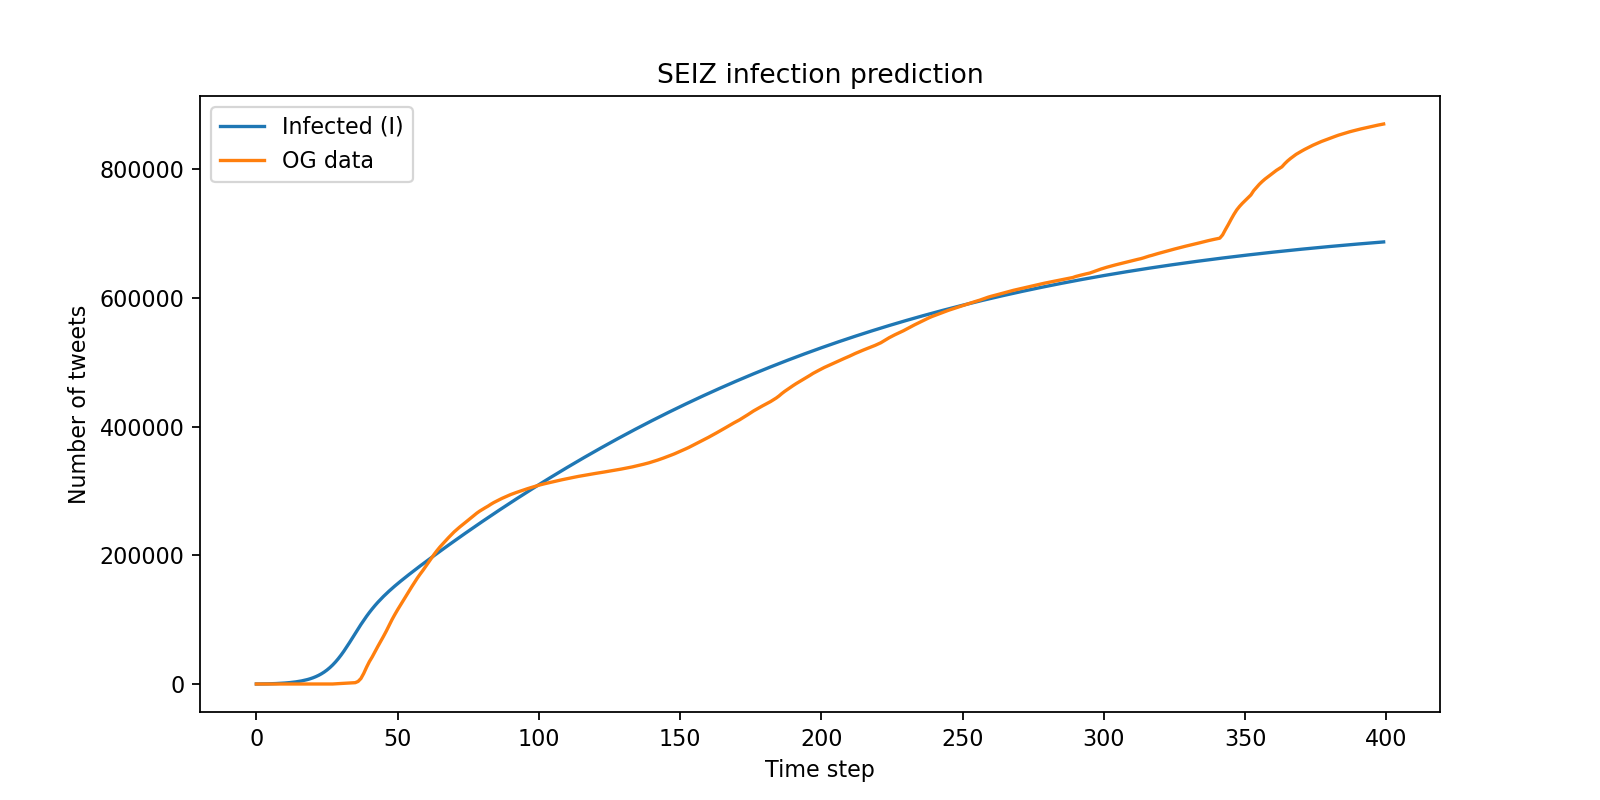

<IPython.core.display.Javascript object>


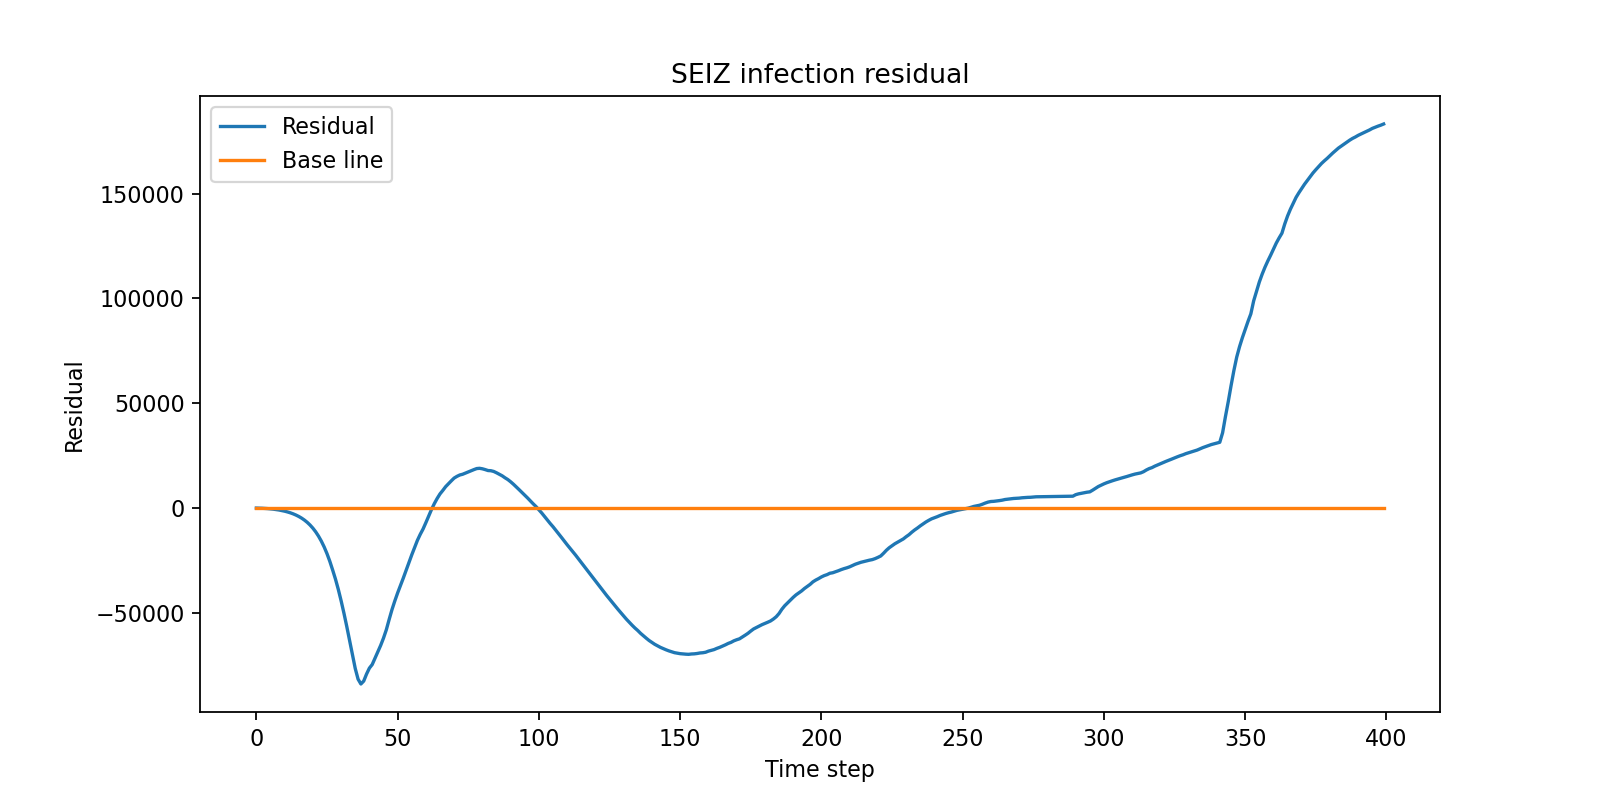

<IPython.core.display.Javascript object>


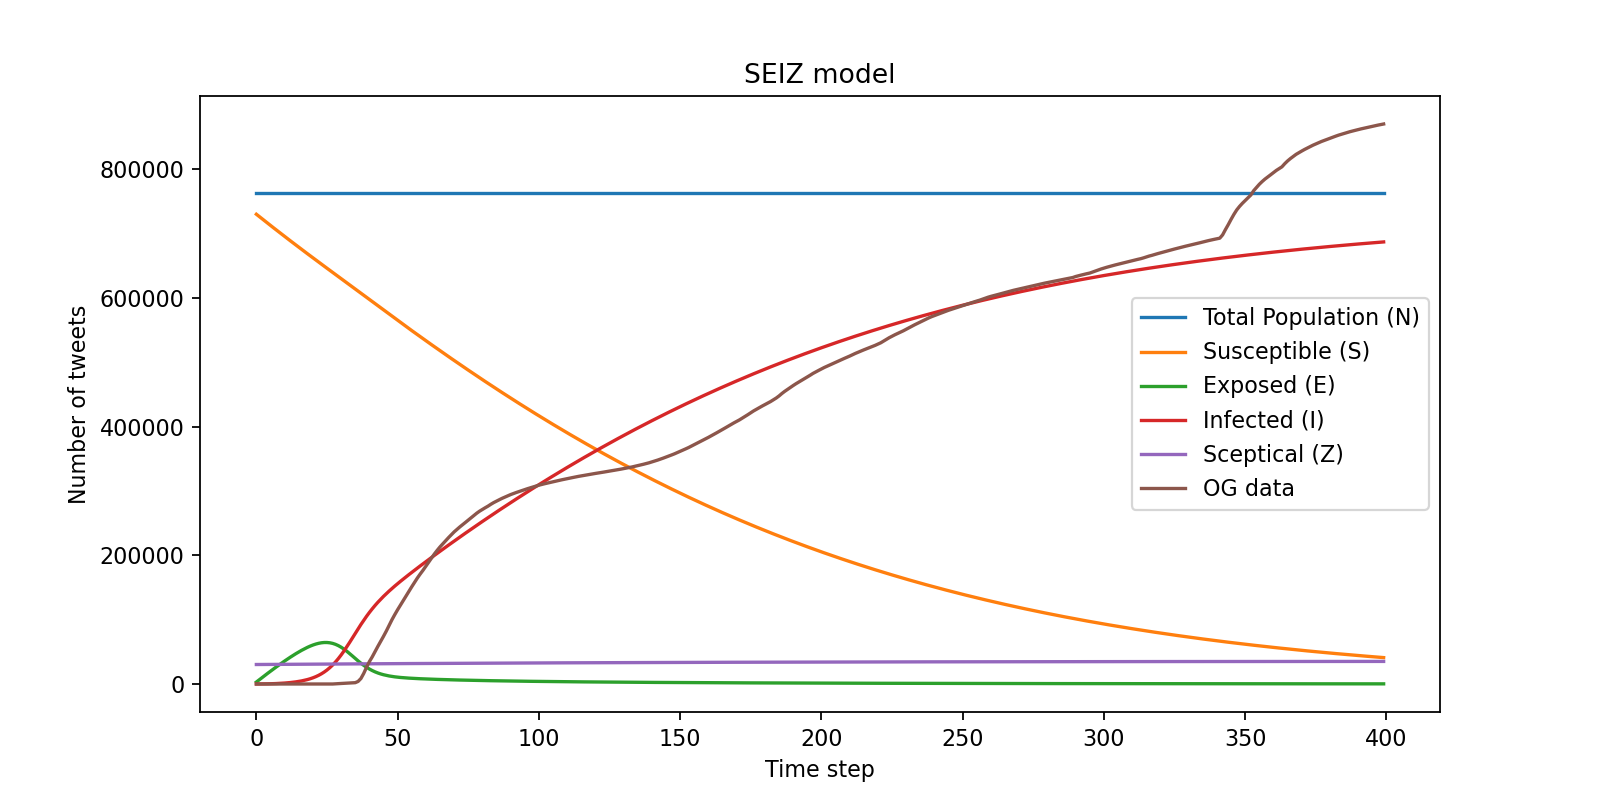

In [24]:
# Run this for the SEIZ model

# Function for SEIZ system of ODEs
# S0, E0, Z0, beta, b, ro, p, e and l are unknown
def seiz(t, y, S0, E0, Z0, beta, b, ro, p, e, l):
    S = y[0]
    E = y[1]
    I = y[2]
    Z = y[3]
    
    N = S0 + E0 + I0 + Z0
    
    dS = -1 * beta * S * (I / N) - b * S * (Z / N)
    dE = (1 - p) * beta * S * (I / N) + (1 - l) * b * S * (Z / N) - ro * E * (I / N) - e * E
    dI = p * beta * S * (I / N) + ro * E * (I / N) + e * E
    dZ = l * b * S * (Z / N)

    return [dS, dE, dI, dZ]

def solve_seiz(x, *args):
    initialValues = [args[0], args[1], I0, args[2]] # [S0, E0, I0, Z0]
    
    return solve_ivp(seiz, tSpan, initialValues, method='BDF', t_eval=x, args=args).y

def fit_seiz(x, *args):
    # Return the solution for the infections which we can then compare to the OG data
    return solve_seiz(x, *args)[2]

initial_guess = [100, 100, 100, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10, 1e-10]
bounds = (0, [9e8, 9e8, 9e8, 100, 100, 100, 1, 1, 1])

popt, pcov = curve_fit(fit_seiz, xData, yData, initial_guess, bounds=bounds)

# Total population
N = round(popt[0] + popt[1] + I0 + popt[2])

print('------------ Estimated Parameters -------------')
print(f'N = {N}')
print(f'S0 = {popt[0]}')
print(f'E0 = {popt[1]}')
print(f'Z0 = {popt[2]}')

print(f'beta = {popt[3]}')
print(f'b = {popt[4]}')
print(f'ro = {popt[5]}')
print(f'p = {popt[6]}')
print(f'e = {popt[7]}')
print(f'l = {popt[8]}')

# Fitted SEIZ model with the guessed args
fitted = solve_seiz(xData, *popt)

infected_residuals = yData - fitted[2]

# Plotting

# Prediction accuracy
plt.figure(figsize=(10, 5))
plt.title('SEIZ infection prediction')

plt.plot(fitted[2], label='Infected (I)')
plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('../images/seiz_odes_infection.png')

plt.show()

# Infection residual
plt.figure(figsize=(10, 5))
plt.title('SEIZ infection residual')

plt.plot(infected_residuals, label='Residual')
plt.plot([0] * len(df), label='Base line')

plt.xlabel('Time step')
plt.ylabel('Residual')

plt.legend()

plt.savefig('../images/seiz_residual.png')

plt.show()

# Whole SEIZ model
plt.figure(figsize=(10, 5))
plt.title('SEIZ model')

plt.plot([N] * len(df), label='Total Population (N)')
plt.plot(fitted[0], label='Susceptible (S)')
plt.plot(fitted[1], label='Exposed (E)')
plt.plot(fitted[2], label='Infected (I)')
plt.plot(fitted[3], label='Sceptical (Z)')

plt.plot(yData, label='OG data')

plt.xlabel('Time step')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('../images/seiz_odes_full.png')

plt.show()

S0 = round(popt[0])
E0 = round(popt[1])
I0 = round(I0)
Z0 = round(popt[2])

beta = popt[3]
b = popt[4]
ro = popt[5]
p = popt[6]
e = popt[7]
l = popt[8]

## Network

In [5]:
# Power law follower distribution
degrees = []

in_degrees = []
out_degrees = []

for i in range(N):
    n = np.random.uniform(1, 330*1e6) # Random number (rank of a twitter user)
    
    follower_count = 1e7*((1 / n)**0.62) # 1e7
    
    degrees.append(round(follower_count))

# We sample the in/out degress from the same array
# This is because for the network the sums of in and out degress have to match
in_degrees = random.sample(degrees, len(degrees))
out_degrees = random.sample(degrees, len(degrees))

print(np.array(degrees).max())

2064


In [6]:
# Scale contact rate parameters for the network

average_degree = (np.array(out_degrees).sum() / N)

# Calculates how much bigger the parameters in the ODEs are
# compared to a network with a specific average out-degree
scaler = (N - 1) / average_degree

# The parameters in the ODEs are proportionally larger because of (1 / N)
# Therefore, we divide by N to scale it back for the networks
beta_ntw = (beta * scaler) / N
b_ntw = (b * scaler) / N
ro_ntw = (ro * scaler) / N

print('------------ Scaled Contact Rate Parameters -------------')
print(f'beta = {beta_ntw}')
print(f'b = {b_ntw}')
print(f'ro = {ro_ntw}')

------------ Scaled Contact Rate Parameters -------------
beta = 0.08501244783811757
b = 0.00381983625354749
ro = 2.6736808521311977


In [7]:
# Creating a directed network and removing self-loops 

G = nx.directed_configuration_model(in_degrees, out_degrees)
G.remove_edges_from(nx.selfloop_edges(G))

<IPython.core.display.Javascript object>


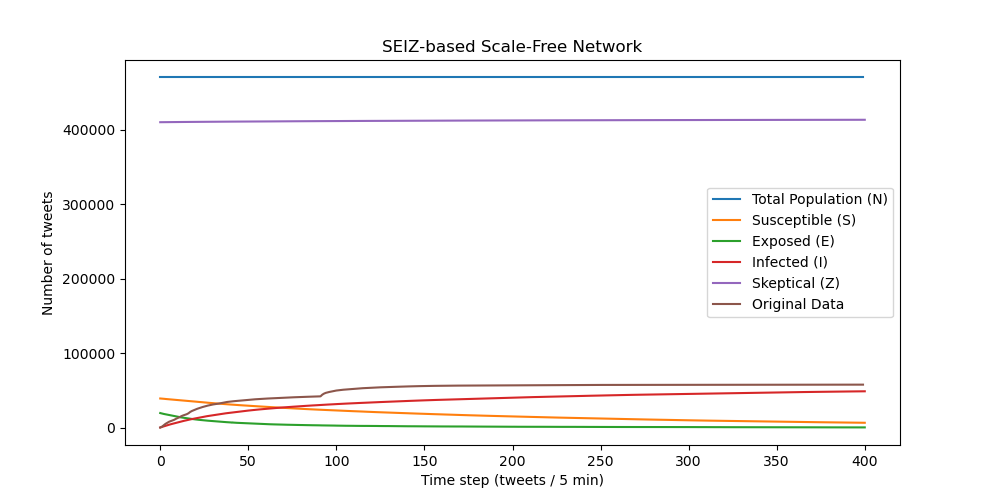

In [8]:
# EoN implementation

# Custom function which sums all rates based on the neighbour amount
# list_nbr is a list of different neighbours to look for (i.e. ['I', 'Z'])
# list_rates is a list of different rates of each list_nbr item
def return_combined_rates(G, node, status, list_nbr, list_rates):
    combined_rate = 0
    
    for i in range(len(list_nbr)):
        nbr_status = list_nbr[i]
        rate = list_rates[i]  
        
        neighbours = len([nbr for nbr in G.neighbors(node) if status[nbr] == nbr_status])
        
        combined_rate += (rate * neighbours)
    
    return combined_rate

# This function needs to return the rate at which node changes status.
def rate_function(G, node, status, parameters):
    beta_ntw, b_ntw, ro_ntw, p, e, l = parameters
    
    if status[node] == 'E':
        return e + return_combined_rates(G, node, status, ['I'], [ro_ntw])
    
    elif status[node] == 'S':
        return return_combined_rates(G, node, status, ['I', 'Z'], [beta_ntw, b_ntw])
    else:
        return 0

# This function needs to return the new status of the node
# This function already implies that the node is changing state
def transition_choice(G, node, status, parameters):
    beta_ntw, b_ntw, ro_ntw, p, e, l = parameters

    if status[node] == 'E':
        return 'I'
    elif status[node] == 'S':
        
        rate_of_infection = return_combined_rates(G, node, status, ['I'], [beta_ntw])
        rate_of_skeptisim = return_combined_rates(G, node, status, ['Z'], [b_ntw])
        
        combined_rate = rate_of_infection + rate_of_skeptisim

        prob_of_infection = rate_of_infection / combined_rate
        prob_of_skeptisim = rate_of_skeptisim / combined_rate
        
        # Depending on the rate of both infection and skeptisim, determine how should
        # the model behave based on probabilities
        if np.random.choice(['I', 'Z'], p=[prob_of_infection, prob_of_skeptisim]) == 'I':
            # If the infection rate is higher than skeptisim
            # that means that the model has a higher probability to become either I or E state
            return np.random.choice(['I', 'E'], p=[p, 1 - p])
        else:
            # If the skeptisim rate is higher than infection
            # that means that the model has a higher probability to become either E or Z state
            return np.random.choice(['E', 'Z'], p=[1 - l, l])


# This function needs to return any node whose rates might change
# because a node has just changed status through "transition_choice" function.
def get_influence_set(G, node, status, parameters):
    # "predecessors" captures all nodes who are following the node which could have become infected
    # Using neighbours here is incorrect!
    return G.predecessors(node)

parameters = (beta_ntw, b_ntw, ro_ntw, p, e, l)

IC = defaultdict(lambda: 'S')

# Setting initial values. Probably could be done in a smarter way :)
for node in range(E0):
    IC[node] = 'E'
    
for node in range(I0):
    IC[node + I0] = 'I'

for node in range(round(Z0)):
    IC[node + (E0 + I0)] = 'Z'


t, S, E, I, Z = EoN.Gillespie_complex_contagion(G, rate_function,
                           transition_choice, get_influence_set, IC,
                           return_statuses=('S', 'E', 'I', 'Z'),
                           parameters=parameters, tmax=400)

plt.figure(figsize=(10, 5))
plt.title('SEIZ-based Scale-Free Network')

plt.plot([N] * len(df), label='Total Population (N)')

plt.plot(t, S, label='Susceptible (S)')
plt.plot(t, E, label='Exposed (E)')
plt.plot(t, I, label='Infected (I)')
plt.plot(t, Z, label='Skeptical (Z)')

plt.plot(yData, label='Original Data')

plt.xlabel('Time step (tweets / 5 min)')
plt.ylabel('Number of tweets')

plt.legend()

plt.savefig('../images/seiz_network.png')

plt.show()